In [ ]:
!pip install transformers datasets scikit-learn nltk matplotlib seaborn tqdm torch pytorch-lightning accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
import torch
import numpy as np
import pytorch_lightning as pl
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import Dataset, DataLoader

# --------------------------------
# 1. Minimal Dataset for SQuAD v2
# --------------------------------
class SQuADDataset(Dataset):
    """
    Minimal PyTorch Dataset for T5 fine-tuning on SQuAD v2.
    Expects each example to have 'question', 'context', 'answers'.
    If 'answers' is empty, set target to "I don't know".
    """
    def __init__(self, data, tokenizer, max_len_input=256, max_len_output=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len_input = max_len_input
        self.max_len_output = max_len_output
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        source_ids = self.inputs[idx]["input_ids"].squeeze()
        source_mask = self.inputs[idx]["attention_mask"].squeeze()

        target_ids = self.targets[idx]["input_ids"].squeeze()
        target_mask = self.targets[idx]["attention_mask"].squeeze()

        # Replace pad tokens with -100 for the loss function
        labels = target_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "labels": labels,
        }

    def _build(self):
        for example in self.data:
            question = example["question"]
            context = example["context"]
            # If no answer text exists, set "I don't know"
            if example["answers"]["text"]:
                answer = example["answers"]["text"][0]
            else:
                answer = "I don't know"

            # Build T5 prompt
            # You can modify the instruction if you like
            input_text = f"question: {question} context: {context} " \
                         f"If you cannot answer based on the context, say 'I don't know.'"
            target_text = answer

            enc_in = self.tokenizer(
                input_text,
                max_length=self.max_len_input,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            enc_out = self.tokenizer(
                target_text,
                max_length=self.max_len_output,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )

            self.inputs.append(enc_in)
            self.targets.append(enc_out)


# ----------------------------
# 2. Lightning Module for T5
# ----------------------------
class T5LitModel(pl.LightningModule):
    def __init__(self, model_name="google/flan-t5-base", lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.lr = lr

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        val_loss = outputs.loss
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr)


# ----------------------------
# 3. Main - Minimal Fine-Tune
# ----------------------------
def main():
    pl.seed_everything(42)

    # 1) Load SQuAD v2
    raw_dataset = load_dataset("squad_v2")
    # Downsample for quick sanity check: 16 train, 16 val
    train_data = raw_dataset["train"].select(range(16))
    val_data = raw_dataset["validation"].select(range(16))

    # 2) Tokenizer
    model_name = "google/flan-t5-base"  # or "t5-base", etc.
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    # 3) Datasets & DataLoaders
    train_dataset = SQuADDataset(train_data, tokenizer)
    val_dataset = SQuADDataset(val_data, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2)

    # 4) Model
    model = T5LitModel(model_name=model_name, lr=3e-5)

    # 5) Trainer
    trainer = pl.Trainer(
        max_epochs=1,
        accelerator="gpu" if torch.cuda.is_available() else "cpu", # use accelerator
        devices=1 if torch.cuda.is_available() else 0, # and devices
        enable_progress_bar=True
    )

    # 6) Fit
    trainer.fit(model, train_loader, val_loader)

    # 7) Print final validation loss
    results = trainer.validate(model, dataloaders=val_loader)
    print("Validation results:", results)

    # 8) Optionally save
    model.model.save_pretrained("mini_flan_t5")
    tokenizer.save_pretrained("mini_flan_t5")
    print("Model saved to mini_flan_t5/")


if __name__ == "__main__":
    main()


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW inste

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.2269923686981201     │
└───────────────────────────┴───────────────────────────┘

Validation results: [{'val_loss': 1.2269923686981201}]
Model saved to mini_flan_t5/


In [ ]:
!pip install --quiet pytorch-lightning transformers datasets accelerate
!pip install --quiet scikit-learn seaborn matplotlib

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda
Loading full SQuAD v2 dataset from Hugging Face...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenizing the training & validation sets...
Train samples: 130319
Validation samples: 11873


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



Starting training for 3 epoch(s)...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 247 M  | eval
------------------------------------------------------------
247 M     Trainable params
0         Non-trainable params
247 M     Total params
990.311   Total estimated model params size (MB)
0         Modules in train mode
565       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.



Training completed in 372.85 minutes.

Evaluating on the full validation set...

Starting final evaluation on the validation set...


Evaluating: 100%|██████████| 11873/11873 [1:23:30<00:00,  2.37it/s]



Evaluation Metrics:
Exact Match: 0.6664
Precision:  0.9065
Recall:     0.6664
F1 Score:   0.6725
Confidence: 0.8616


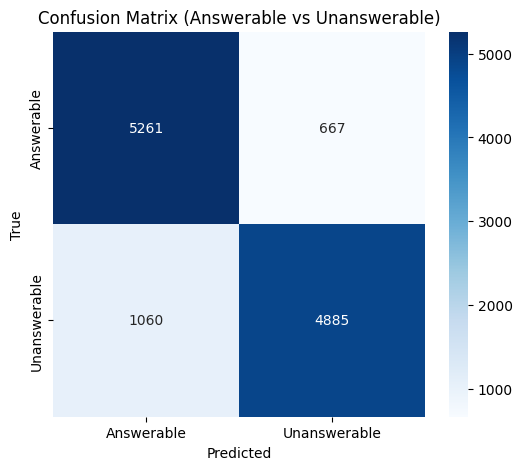

Prediction details saved to 'baseline_results.json'
Fine-tuned model saved to 'fine_tuned_flan_t5'


In [ ]:
import os
import json
import time
import copy
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    AdamW
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix
)

#######################################
# 1) Configuration & Hyperparameters
#######################################
class Args:
    num_workers = 2          # Adjust based on your system
    batch_size = 8           # Increase/decrease based on GPU memory
    learning_rate = 1e-4     # Lower it if you see NaNs or instability
    eps = 1e-8
    weight_decay = 0.0
    max_epochs = 3           # Increase for better results
    model_name = "google/flan-t5-base"  # Or "google/flan-t5-large", etc.

args = Args()


#######################################
# 2) QGDataset for SQuAD v2
#######################################
class QGDataset(Dataset):
    """
    Loads SQuAD v2 examples in T5 prompt style.
    If answers["text"] is empty => "I don't know"
    """
    def __init__(self, tokenizer, data, max_len_input=384, max_len_output=64):
        self.tokenizer = tokenizer
        self.data = data
        self.max_len_input = max_len_input
        self.max_len_output = max_len_output
        self.inputs = []
        self.targets = []
        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        source_ids = self.inputs[idx]['input_ids'].squeeze()
        source_mask = self.inputs[idx]['attention_mask'].squeeze()
        target_ids = self.targets[idx]['input_ids'].squeeze()
        target_mask = self.targets[idx]['attention_mask'].squeeze()

        # Replace pad token with -100 for loss ignoring
        labels = copy.deepcopy(target_ids)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_ids,
            'attention_mask': source_mask,
            'labels': labels
        }

    def _build(self):
        for example in self.data:
            question = example["question"]
            context = example["context"]
            # If no answer text, we treat it as "I don't know"
            if example["answers"]["text"]:
                answer = example["answers"]["text"][0]
            else:
                answer = "I don't know"

            # T5-style prompt
            input_text = (
                f"question: {question} context: {context} "
                f"If you cannot answer based on the context, say 'I don't know.'"
            )

            enc_in = self.tokenizer(
                input_text,
                max_length=self.max_len_input,
                padding="max_length",
                truncation=True,
                return_tensors='pt'
            )
            enc_out = self.tokenizer(
                answer,
                max_length=self.max_len_output,
                padding="max_length",
                truncation=True,
                return_tensors='pt'
            )

            self.inputs.append(enc_in)
            self.targets.append(enc_out)


#######################################
# 3) PyTorch Lightning Module
#######################################
class T5FineTuner(pl.LightningModule):
    """
    Trains T5 (or FLAN-T5) on question-answer style data.
    """
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.model = T5ForConditionalGeneration.from_pretrained(self.args.model_name)

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        val_loss = outputs.loss
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)
        return val_loss

    def configure_optimizers(self):
        return AdamW(
            self.parameters(),
            lr=self.args.learning_rate,
            eps=self.args.eps,
            weight_decay=self.args.weight_decay
        )


#######################################
# 4) Evaluation Function
#######################################
def evaluate_model(model, tokenizer, dataset_split, device):
    """
    Generates answers for the entire dataset_split,
    computes exact match, weighted precision/recall/f1,
    average confidence, and returns per-example predictions.
    """

    y_true = []
    y_pred = []
    confidences = []
    question_types = []

    model.eval().to(device)

    print("\nStarting final evaluation on the validation set...")
    for example in tqdm(dataset_split, desc="Evaluating"):
        question = example["question"]
        context = example["context"]

        # Gold / True Answer
        if example["answers"]["text"]:
            true_answer = example["answers"]["text"][0]
            question_type = "Answerable"
        else:
            true_answer = "I don't know"
            question_type = "Unanswerable"

        # Build input prompt
        input_text = (
            f"question: {question} context: {context} "
            "If you cannot answer based on the context, say 'I don't know.'"
        )
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=384,
            truncation=True,
            padding="max_length"
        ).to(device)

        # Generate answer
        with torch.no_grad():
            generated_ids = model.generate(**inputs, max_length=64, num_beams=4)
        pred_answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Confidence from first decoder token
        with torch.no_grad():
            logits = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                decoder_input_ids=torch.tensor([[tokenizer.pad_token_id]]).to(device)
            ).logits
            probs = torch.softmax(logits, dim=-1)
            confidence = torch.max(probs[0]).item()

        # Store
        y_true.append(true_answer.strip())
        y_pred.append(pred_answer.strip())
        confidences.append(confidence)
        question_types.append(question_type)

    # Compute metrics
    exact_matches = sum([1 for t, p in zip(y_true, y_pred) if t == p])
    exact_match = exact_matches / len(y_true)

    # Weighted precision/recall/f1 (string-based)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=1
    )
    avg_confidence = sum(confidences) / len(confidences)

    return {
        "exact_match": exact_match,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "avg_confidence": avg_confidence
    }, y_true, y_pred, confidences, question_types


#######################################
# 5) Plotting Helper (Confusion Matrix)
#######################################
def plot_confusion_matrix(y_true, y_pred):
    """
    Splits predictions into "Answerable" vs. "Unanswerable"
    based on whether the string is "I don't know".
    Plots a confusion matrix using seaborn.
    """
    true_labels = ["Answerable" if ans != "I don't know" else "Unanswerable" for ans in y_true]
    pred_labels = ["Answerable" if ans != "I don't know" else "Unanswerable" for ans in y_pred]

    cm = confusion_matrix(true_labels, pred_labels, labels=["Answerable", "Unanswerable"])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title("Confusion Matrix (Answerable vs Unanswerable)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


#######################################
# 6) Main Training + Full Evaluation
#######################################
def main():
    pl.seed_everything(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 1) Load the full SQuAD v2 dataset (train + validation)
    print("Loading full SQuAD v2 dataset from Hugging Face...")
    raw_dataset = load_dataset("squad_v2")  # ~130k train, ~11k validation

    # Train / Validation data
    train_data = raw_dataset["train"]       # FULL training set
    val_data = raw_dataset["validation"]    # FULL dev set

    # 2) Tokenizer
    tokenizer = T5Tokenizer.from_pretrained(args.model_name)

    # 3) Build PyTorch datasets
    print("Tokenizing the training & validation sets...")
    train_dataset = QGDataset(tokenizer, train_data, max_len_input=384, max_len_output=64)
    val_dataset = QGDataset(tokenizer, val_data, max_len_input=384, max_len_output=64)
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # 4) DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                              shuffle=True, num_workers=args.num_workers)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                            shuffle=False, num_workers=args.num_workers)

    # 5) Initialize LightningModule
    model_module = T5FineTuner(args)

    # 6) Trainer
    trainer = pl.Trainer(
        max_epochs=args.max_epochs,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else 0,
        enable_progress_bar=True
    )

    # 7) Training
    start_time = time.time()
    print(f"\nStarting training for {args.max_epochs} epoch(s)...")
    trainer.fit(model_module, train_loader, val_loader)
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time/60:.2f} minutes.")

    # 8) Final Evaluation on Validation Set
    print("\nEvaluating on the full validation set...")
    fine_tuned_model = model_module.model
    metrics, y_true, y_pred, confidences, question_types = evaluate_model(
        fine_tuned_model, tokenizer, val_data, device
    )
    print("\nEvaluation Metrics:")
    print(f"Exact Match: {metrics['exact_match']:.4f}")
    print(f"Precision:  {metrics['precision']:.4f}")
    print(f"Recall:     {metrics['recall']:.4f}")
    print(f"F1 Score:   {metrics['f1_score']:.4f}")
    print(f"Confidence: {metrics['avg_confidence']:.4f}")

    # 9) Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # 10) Save results to JSON
    output_file = "baseline_results.json"
    results_json = []
    for i, example in enumerate(val_data):
        results_json.append({
            "question": example["question"],
            "context": example["context"],
            "true_answer": y_true[i],
            "predicted_answer": y_pred[i],
            "confidence": confidences[i],
            "question_type": question_types[i],
        })
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(results_json, f, indent=4, ensure_ascii=False)
    print(f"Prediction details saved to '{output_file}'")

    # 11) Save fine-tuned model
    save_dir = "fine_tuned_flan_t5"
    os.makedirs(save_dir, exist_ok=True)
    fine_tuned_model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Fine-tuned model saved to '{save_dir}'")


if __name__ == "__main__":
    main()


In [ ]:
import shutil
from google.colab import files

# 1) Zip the entire directory containing your saved model/tokenizer
shutil.make_archive("fine_tuned_flan_t5", "zip", "fine_tuned_flan_t5")

# 2) Download the zipped model to your local machine
files.download("fine_tuned_flan_t5.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install matplotlib seaborn pandas

Saving baseline_results.json to baseline_results.json


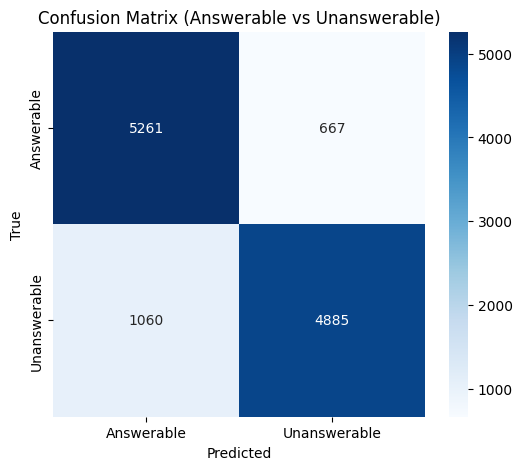

In [ ]:
# prompt: I want to upload baseline_results.json via dialog and call plotting functions below

from google.colab import files
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

uploaded = files.upload()

def plot_confusion_matrix(y_true, y_pred):
    """
    Splits predictions into "Answerable" vs. "Unanswerable"
    based on whether the string is "I don't know".
    Plots a confusion matrix using seaborn.
    """
    true_labels = ["Answerable" if ans != "I don't know" else "Unanswerable" for ans in y_true]
    pred_labels = ["Answerable" if ans != "I don't know" else "Unanswerable" for ans in y_pred]

    cm = confusion_matrix(true_labels, pred_labels, labels=["Answerable", "Unanswerable"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title("Confusion Matrix (Answerable vs Unanswerable)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def main():
    for fn in uploaded.keys():
        if fn == "baseline_results.json":
            with open(fn, 'r') as f:
                results = json.load(f)
            y_true = [item["true_answer"] for item in results]
            y_pred = [item["predicted_answer"] for item in results]
            plot_confusion_matrix(y_true, y_pred)
            break
    else:
        print("baseline_results.json not found in uploaded files.")

if __name__ == "__main__":
    main()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

#####################################
# A) Metrics Bar Chart
#####################################
def visualize_results(metrics):
    """
    Creates a bar chart of the main metrics:
      - exact_match
      - f1_score
      - precision
      - recall
      - avg_confidence
    """
    exact_match = metrics["exact_match"]
    f1_score = metrics["f1_score"]
    precision = metrics["precision"]
    recall = metrics["recall"]
    avg_confidence = metrics["avg_confidence"]

    labels = ["Exact Match", "F1 Score", "Precision", "Recall", "Avg Confidence"]
    values = [exact_match, f1_score, precision, recall, avg_confidence]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values,
                   color=["blue", "green", "orange", "purple", "red"],
                   alpha=0.7)
    plt.ylim(0, 1)
    plt.title("Evaluation Metrics")
    plt.ylabel("Score (0 to 1)")
    plt.xticks(rotation=45)

    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.05,
            f"{height:.4f}",
            ha="center",
            color="white",
            fontsize=11,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()


#####################################
# B) Confusion Matrix (Answerable vs. Unanswerable)
#####################################
def plot_confusion_matrix_from_results(results_data):
    """
    Builds a confusion matrix by treating:
      - "I don't know" => Unanswerable
      - Anything else => Answerable
    """
    y_true, y_pred = [], []

    for r in results_data:
        # If the true answer is "I don't know" => Unanswerable
        if r["true_answer"].strip() == "I don't know":
            y_true.append("Unanswerable")
        else:
            y_true.append("Answerable")

        # If the predicted answer is "I don't know" => Unanswerable
        if r["predicted_answer"].strip() == "I don't know":
            y_pred.append("Unanswerable")
        else:
            y_pred.append("Answerable")

    cm = confusion_matrix(y_true, y_pred, labels=["Answerable", "Unanswerable"])

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title("Confusion Matrix (Answerable vs Unanswerable)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


#####################################
# C) Confidence Distribution by Question Type
#####################################
def plot_confidences_with_question_type(results_data):
    """
    Box plot and violin plot of model confidence,
    grouped by question_type (Answerable vs. Unanswerable).
    """
    # Convert to DataFrame
    data = []
    for r in results_data:
        data.append({
            "Question Type": r["question_type"],
            "Confidence": r["confidence"]
        })
    df = pd.DataFrame(data)

    # Box Plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Question Type", y="Confidence", palette="Set2")
    plt.title("Confidence Distribution by Question Type (Box Plot)")
    plt.xlabel("Question Type")
    plt.ylabel("Confidence")
    plt.show()

    # Violin Plot
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x="Question Type", y="Confidence",
                   palette="Set2", inner="quartile")
    plt.title("Confidence Distribution by Question Type (Violin Plot)")
    plt.xlabel("Question Type")
    plt.ylabel("Confidence")
    plt.show()
